# Contents
* [Introduction](#Introduction)
* [Imports and configuration](#Imports-and-configuration)
* [Data loading](#Data-loading)
* [Setup](#Setup)
* [Score models](#Score-models)
* [Prediction correlation](#Prediction-correlation)
* [Results](#Results)
* [Discussion](#Discussion)

# Introduction

This notebook compares the multinomial classification performance of selected models trained on data with outliers removed and without.

# Imports and configuration

In [1]:
from time import time

notebook_begin_time = time()

# set random seeds

from os import environ
from random import seed as random_seed
from numpy.random import seed as np_seed
from tensorflow.random import set_seed


def reset_seeds(seed: int) -> None:
    """Utility function for resetting random seeds"""
    environ["PYTHONHASHSEED"] = str(seed)
    random_seed(seed)
    np_seed(seed)
    set_seed(seed)


reset_seeds(SEED := 2021)
del environ
del random_seed
del np_seed
del set_seed
del reset_seeds

In [2]:
# extensions
%load_ext autotime
%load_ext lab_black
%load_ext nb_black

In [3]:
# core
import numpy as np
import pandas as pd

# utility
from collections import namedtuple
from gc import collect as gc_collect
from tqdm.notebook import tqdm

# typing
from typing import Any, Dict, List

# faster pandas & sklearn
import swifter
from sklearnex import patch_sklearn

patch_sklearn()
del patch_sklearn

# metrics
from imblearn.metrics import geometric_mean_score
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    f1_score,
    roc_auc_score,
)

# classifiers
from sklearn.linear_model import (
    LogisticRegressionCV,
    RidgeClassifierCV,
    SGDClassifier,
)
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC, SVC

# visualization
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("notebook")
%matplotlib inline

# display outputs w/o print calls
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
del InteractiveShell

# hide warnings
import warnings

warnings.filterwarnings("ignore")
del warnings

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


time: 3.98 s


In [4]:
# Location of cross validation data
FRILL_FEATHERS_FOLDER = "../10.0-mic-prepare_train-test_splits_on_full_data"

# Location where this notebook will output
DATA_OUT_FOLDER = "."

_ = gc_collect()

time: 168 ms


# Setup

In this section, we define some structures to keep track of models and scores.

In [5]:
MODELS = {
    "GaussianNB": lambda: GaussianNB(),
    "LinearSVC": lambda: LinearSVC(random_state=SEED),
    "LogRegCV_b": lambda: LogisticRegressionCV(
        scoring="balanced_accuracy",
        class_weight="balanced",
        n_jobs=-1,
        random_state=SEED,
    ),
    "RidgeCV_b": lambda: RidgeClassifierCV(
        scoring="balanced_accuracy", class_weight="balanced"
    ),
    "RidgeCV": lambda: RidgeClassifierCV(scoring="balanced_accuracy"),
    "SGD": lambda: SGDClassifier(n_jobs=-1, random_state=SEED),
    "SGD_b": lambda: SGDClassifier(
        n_jobs=-1, random_state=SEED, class_weight="balanced"
    ),
    "SVC": lambda: SVC(random_state=SEED),
    "SVC_b": lambda: SVC(class_weight="balanced", random_state=SEED),
}

_ = gc_collect()

time: 126 ms


In [6]:
METRICS = (
    "accuracy",
    "adjusted_balanced_accuracy",
    "balanced_accuracy",
    "f1",
    "geometric_mean",
    "roc_auc",
    "fit_time",
    "predict_time",
)

# to be cast to pd.DataFrame
make_results = lambda: {key: [] for key in {"model_name", "case", "LOF", *METRICS}}
results_ = make_results()

AvgScores = namedtuple("AvgScores", METRICS)


def store_result(
    where: Dict[str, List],
    model_name: str,
    case: str,
    LOF: str,
    avg_scores: AvgScores,
) -> None:
    "Appends a model's scores and fit/predict times to the results dict."
    for attribute, value in {
        "model_name": model_name,
        "case": case,
        "LOF": LOF,
        **avg_scores._asdict(),
    }.items():
        where[attribute].append(value)


ALL_CASES = {"ternary"}

_ = gc_collect()

time: 133 ms


In [7]:
predictions_ = {key: [] for key in {"model", "case", "LOF", "fold", "y_pred"}}

Prediction = namedtuple("Prediction", predictions_.keys())


def store_prediction(where: Dict[str, List], prediction: Prediction) -> None:
    "Records the y_pred of a classifier on a fold"
    for k, v in prediction._asdict().items():
        where[k].append(v)


_ = gc_collect()

time: 110 ms


In [8]:
def print_and_append(to_append: Any, append_to: List[Any]) -> List[Any]:
    """Given an object and a list, pass the object to print() and then append it to the list, which is returned"""
    print(to_append)
    append_to.append(to_append)
    return append_to


def prep_y_pred(label: int) -> np.ndarray:
    """Prepares labels for AUROC scoring"""
    _ = [0, 0, 0]
    _[label] = 1
    return np.asarray(_, dtype=np.float16)


SUFFIX_DICT = {
    "minkowski": "LOF",
    "untransformed": "untransformed",
}


def evaluate_model(
    model_base: str,
    case: str = "ternary",
    distance_metric: str = "untransformed",
    track_fold_time: bool = True,
) -> AvgScores:
    """Evaluate a model with cross validation on prepared folds."""

    (
        fit_times,
        predict_times,
        accuracy,
        adjusted_balanced_accuracy,
        balanced_accuracy,
        f1,
        geometric_mean,
        roc_auc,
    ) = ([] for _ in range(8))
    fold_num = 0
    while True:
        if track_fold_time:
            fold_begin = time()

        # helper function
        read_feather_cv = lambda _set: pd.read_feather(
            f"{FRILL_FEATHERS_FOLDER}/cv_{fold_num}/{_set}_{'untransformed' if 'test' in _set else SUFFIX_DICT[distance_metric]}.feather"
        )

        # load training data
        try:
            X_train: pd.DataFrame = read_feather_cv("X_train")
            y_train: pd.Series = read_feather_cv("y_train").iloc[:, 0]
        except FileNotFoundError:
            break

        # initialize model
        model = MODELS[model_base]()

        # fit
        begin = time()
        model.fit(X_train, y_train)
        end = time()
        del X_train
        del y_train
        _ = gc_collect()
        fit_times.append(end - begin)
        print(f"fitted in {end - begin:.2f} s")

        # load test data
        X_test = read_feather_cv("X_test")

        # predict
        begin = time()
        predicted = model.predict(X_test)
        end = time()
        try:
            proba_predict = model.predict_proba(X_test)
        except AttributeError:
            # some classifiers do not support .predict_proba
            proba_predict = np.stack(pd.Series(predicted).swifter.apply(prep_y_pred))
        del X_test
        del model
        _ = gc_collect()
        predict_times.append(end - begin)
        print(f"predicted in {end - begin:.2f} s")
        del end
        del begin
        _ = gc_collect()
        store_prediction(
            where=predictions_,
            prediction=Prediction(
                model=model_base,
                case=case,
                LOF=distance_metric,
                fold=fold_num,
                y_pred=predicted,
            ),
        )

        # score
        score_params = {
            "y_true": read_feather_cv("y_test").iloc[:, 0],
            "y_pred": predicted,
        }
        print("accuracy: ", end="")
        accuracy = print_and_append(
            to_append=accuracy_score(**score_params), append_to=accuracy
        )
        print("adjusted balanced accuracy: ", end="")
        adjusted_balanced_accuracy = print_and_append(
            to_append=balanced_accuracy_score(**score_params, adjusted=True),
            append_to=adjusted_balanced_accuracy,
        )
        print("balanced accuracy: ", end="")
        balanced_accuracy = print_and_append(
            to_append=balanced_accuracy_score(**score_params),
            append_to=balanced_accuracy,
        )
        print("f1: ", end="")
        f1 = print_and_append(
            to_append=f1_score(**score_params, average="weighted"), append_to=f1
        )
        print("geometric mean: ", end="")
        geometric_mean = print_and_append(
            to_append=geometric_mean_score(**score_params), append_to=geometric_mean
        )
        print("roc auc: ", end="")
        roc_auc = print_and_append(
            to_append=roc_auc_score(
                y_true=score_params["y_true"],
                y_score=proba_predict,
                average="weighted",
                multi_class="ovo",
            ),
            append_to=roc_auc,
        )
        del score_params
        del predicted
        del proba_predict
        _ = gc_collect()

        if track_fold_time:
            print(
                f"{model_base} fold {fold_num + 1} completed in {time() - fold_begin:.2f} s"
            )
            del fold_begin

        fold_num += 1
        _ = gc_collect()

    return AvgScores(
        *[
            np.mean(_)
            for _ in (
                accuracy,
                adjusted_balanced_accuracy,
                balanced_accuracy,
                f1,
                geometric_mean,
                roc_auc,
                fit_times,
                predict_times,
            )
        ]
    )


case = "ternary"

_ = gc_collect()

time: 126 ms


# Score models

In [9]:
for model in tqdm(MODELS):
    for distance in {"minkowski", "untransformed"}:
        print(f"evaluating {model}...")
        eval_begin = time()
        store_result(
            where=results_,
            model_name=model,
            case="ternary",
            LOF=distance,
            avg_scores=evaluate_model(model_base=model, distance_metric=distance),
        )
        print(f"stored {model} in {time() - eval_begin:.2f} s")
        del eval_begin
        _ = gc_collect()

  0%|          | 0/9 [00:00<?, ?it/s]

evaluating GaussianNB...
fitted in 3.38 s
predicted in 0.71 s
accuracy: 0.49622054246331704
adjusted balanced accuracy: 0.1890063435112241
balanced accuracy: 0.4593375623408161
f1: 0.5046716807132645
geometric mean: 0.4520970725223114
roc auc: 0.6580272524689587
GaussianNB fold 1 completed in 6.16 s
fitted in 2.97 s
predicted in 0.64 s
accuracy: 0.5063346060395696
adjusted balanced accuracy: 0.19400025331091633
balanced accuracy: 0.4626668355406109
f1: 0.5091697009715328
geometric mean: 0.4553549166421429
roc auc: 0.6599445579058827
GaussianNB fold 2 completed in 5.41 s
fitted in 2.66 s
predicted in 1.14 s
accuracy: 0.5046845074796832
adjusted balanced accuracy: 0.24769728435297192
balanced accuracy: 0.4984648562353146
f1: 0.513563780354899
geometric mean: 0.49481567185190584
roc auc: 0.6897781881530166
GaussianNB fold 3 completed in 6.26 s
fitted in 2.58 s
predicted in 1.62 s
accuracy: 0.5052350963953174
adjusted balanced accuracy: 0.2125223476999607
balanced accuracy: 0.4750148984666

Pandas Apply: 100%|██████████| 13494/13494 [00:00<00:00, 135746.65it/s]


predicted in 0.46 s
accuracy: 0.639098858752038
adjusted balanced accuracy: 0.30568245771052366
balanced accuracy: 0.5371216384736824
f1: 0.6167408028390293
geometric mean: 0.48048617839331287
roc auc: 0.6496208983032123
LinearSVC fold 1 completed in 736.27 s
fitted in 711.41 s


Pandas Apply: 100%|██████████| 11524/11524 [00:00<00:00, 149179.37it/s]


predicted in 0.36 s
accuracy: 0.6567164179104478
adjusted balanced accuracy: 0.34558971372788155
balanced accuracy: 0.5637264758185877
f1: 0.6409191027975828
geometric mean: 0.5213752057787587
roc auc: 0.6697111451426127
LinearSVC fold 2 completed in 713.66 s
fitted in 672.89 s


Pandas Apply: 100%|██████████| 19319/19319 [00:00<00:00, 203093.30it/s]


predicted in 0.60 s
accuracy: 0.5939748434183963
adjusted balanced accuracy: 0.2729722197003616
balanced accuracy: 0.5153148131335744
f1: 0.5784584280204564
geometric mean: 0.4703671337459472
roc auc: 0.6380121125450646
LinearSVC fold 3 completed in 675.41 s
fitted in 570.98 s


Pandas Apply: 100%|██████████| 25883/25883 [00:00<00:00, 190837.53it/s]


predicted in 0.76 s
accuracy: 0.5951396669628713
adjusted balanced accuracy: 0.27122552166755765
balanced accuracy: 0.5141503477783718
f1: 0.5769296459763249
geometric mean: 0.45755803975488246
roc auc: 0.6355944150364659
LinearSVC fold 4 completed in 573.54 s
fitted in 593.58 s


Pandas Apply: 100%|██████████| 16532/16532 [00:00<00:00, 191270.21it/s]


predicted in 0.45 s
accuracy: 0.5759133801112993
adjusted balanced accuracy: 0.2781712172548108
balanced accuracy: 0.5187808115032072
f1: 0.560035891864724
geometric mean: 0.472515243527292
roc auc: 0.6422619307073444
LinearSVC fold 5 completed in 595.75 s
stored LinearSVC in 3295.20 s
evaluating LinearSVC...
fitted in 656.17 s


Pandas Apply: 100%|██████████| 13494/13494 [00:00<00:00, 136766.49it/s]


predicted in 0.38 s
accuracy: 0.638728323699422
adjusted balanced accuracy: 0.30526641404649874
balanced accuracy: 0.5368442760309992
f1: 0.6163708932979308
geometric mean: 0.4797879282011429
roc auc: 0.6493360198678146
LinearSVC fold 1 completed in 658.30 s
fitted in 759.26 s


Pandas Apply: 100%|██████████| 11524/11524 [00:00<00:00, 252013.39it/s]


predicted in 0.33 s
accuracy: 0.6557618882332523
adjusted balanced accuracy: 0.34342574728898373
balanced accuracy: 0.5622838315259892
f1: 0.6399062582091437
geometric mean: 0.5202939728090716
roc auc: 0.6685411896483215
LinearSVC fold 2 completed in 761.33 s
fitted in 693.08 s


Pandas Apply: 100%|██████████| 19319/19319 [00:00<00:00, 210707.17it/s]


predicted in 0.59 s
accuracy: 0.5958900564211398
adjusted balanced accuracy: 0.2751812297967337
balanced accuracy: 0.5167874865311558
f1: 0.5801239346556453
geometric mean: 0.4708407739723956
roc auc: 0.6393438228184231
LinearSVC fold 3 completed in 695.39 s
fitted in 602.19 s


Pandas Apply: 100%|██████████| 25883/25883 [00:00<00:00, 155952.70it/s]


predicted in 0.77 s
accuracy: 0.5951396669628713
adjusted balanced accuracy: 0.2700720111028963
balanced accuracy: 0.5133813407352642
f1: 0.5765561661619625
geometric mean: 0.45628679136375605
roc auc: 0.634905648525858
LinearSVC fold 4 completed in 604.73 s
fitted in 702.41 s


Pandas Apply: 100%|██████████| 16532/16532 [00:00<00:00, 153899.26it/s]


predicted in 0.48 s
accuracy: 0.576336801354948
adjusted balanced accuracy: 0.279344418989732
balanced accuracy: 0.5195629459931547
f1: 0.5606761539111308
geometric mean: 0.4739920936532993
roc auc: 0.6428175336725142
LinearSVC fold 5 completed in 704.64 s
stored LinearSVC in 3424.94 s
evaluating LogRegCV_b...
fitted in 502.89 s
predicted in 0.39 s
accuracy: 0.5981176819327109
adjusted balanced accuracy: 0.3897729028714103
balanced accuracy: 0.5931819352476069
f1: 0.6044267771061312
geometric mean: 0.5873061334092012
roc auc: 0.7695218424387095
LogRegCV_b fold 1 completed in 505.46 s
fitted in 502.93 s
predicted in 0.33 s
accuracy: 0.6104651162790697
adjusted balanced accuracy: 0.41898677317806016
balanced accuracy: 0.6126578487853734
f1: 0.6192182298772945
geometric mean: 0.6102447713314858
roc auc: 0.7918100382399417
LogRegCV_b fold 2 completed in 505.66 s
fitted in 462.52 s
predicted in 0.61 s
accuracy: 0.5551529582276515
adjusted balanced accuracy: 0.34643935377418095
balanced accu

Pandas Apply: 100%|██████████| 13494/13494 [00:00<00:00, 144536.99it/s]


predicted in 0.35 s
accuracy: 0.59322661923818
adjusted balanced accuracy: 0.3895152063079831
balanced accuracy: 0.5930101375386554
f1: 0.6000963299156395
geometric mean: 0.5878716652687456
roc auc: 0.6859642901472759
RidgeCV_b fold 1 completed in 38.80 s
fitted in 38.04 s


Pandas Apply: 100%|██████████| 11524/11524 [00:00<00:00, 208357.37it/s]


predicted in 0.32 s
accuracy: 0.6093370357514751
adjusted balanced accuracy: 0.4268273779131504
balanced accuracy: 0.6178849186087669
f1: 0.6183546281749047
geometric mean: 0.6155120960139916
roc auc: 0.7042834804744575
RidgeCV_b fold 2 completed in 40.21 s
fitted in 34.30 s


Pandas Apply: 100%|██████████| 19319/19319 [00:00<00:00, 180099.75it/s]


predicted in 0.62 s
accuracy: 0.5540659454423107
adjusted balanced accuracy: 0.3345841793756796
balanced accuracy: 0.5563894529171197
f1: 0.5621943019520276
geometric mean: 0.5523934721959279
roc auc: 0.6650256213365804
RidgeCV_b fold 3 completed in 36.81 s
fitted in 31.41 s


Pandas Apply: 100%|██████████| 25883/25883 [00:00<00:00, 186406.31it/s]


predicted in 0.78 s
accuracy: 0.5483522002859019
adjusted balanced accuracy: 0.3197943497234155
balanced accuracy: 0.546529566482277
f1: 0.553611125927502
geometric mean: 0.5368514433728432
roc auc: 0.6552794709850315
RidgeCV_b fold 4 completed in 34.13 s
fitted in 36.65 s


Pandas Apply: 100%|██████████| 16532/16532 [00:00<00:00, 256194.17it/s]


predicted in 0.50 s
accuracy: 0.5457899830631503
adjusted balanced accuracy: 0.3225000123217916
balanced accuracy: 0.5483333415478611
f1: 0.545675298274423
geometric mean: 0.5375991129046594
roc auc: 0.6607694959055381
RidgeCV_b fold 5 completed in 38.90 s
stored RidgeCV_b in 189.42 s
evaluating RidgeCV_b...
fitted in 38.41 s


Pandas Apply: 100%|██████████| 13494/13494 [00:00<00:00, 115036.23it/s]


predicted in 0.40 s
accuracy: 0.5923373351119016
adjusted balanced accuracy: 0.3898038863597013
balanced accuracy: 0.5932025909064675
f1: 0.5996493071383227
geometric mean: 0.5888321871242648
roc auc: 0.6862706666418598
RidgeCV_b fold 1 completed in 40.63 s
fitted in 37.96 s


Pandas Apply: 100%|██████████| 11524/11524 [00:00<00:00, 180164.82it/s]


predicted in 0.35 s
accuracy: 0.6096841374522736
adjusted balanced accuracy: 0.42649785252979555
balanced accuracy: 0.6176652350198637
f1: 0.6187799709336657
geometric mean: 0.6153316447858247
roc auc: 0.704324804664795
RidgeCV_b fold 2 completed in 40.13 s
fitted in 34.85 s


Pandas Apply: 100%|██████████| 19319/19319 [00:00<00:00, 166124.59it/s]


predicted in 0.60 s
accuracy: 0.5559811584450541
adjusted balanced accuracy: 0.3370892042543934
balanced accuracy: 0.558059469502929
f1: 0.5640155025179122
geometric mean: 0.5535957760013144
roc auc: 0.666468929663547
RidgeCV_b fold 3 completed in 37.29 s
fitted in 38.36 s


Pandas Apply: 100%|██████████| 25883/25883 [00:00<00:00, 145080.17it/s]


predicted in 0.83 s
accuracy: 0.5497044392072017
adjusted balanced accuracy: 0.3211137731542804
balanced accuracy: 0.5474091821028536
f1: 0.5548879856623364
geometric mean: 0.5377757019365863
roc auc: 0.6559837316163929
RidgeCV_b fold 4 completed in 41.17 s
fitted in 39.94 s


Pandas Apply: 100%|██████████| 16532/16532 [00:00<00:00, 165222.07it/s]


predicted in 0.46 s
accuracy: 0.5468787805468183
adjusted balanced accuracy: 0.32541045668705443
balanced accuracy: 0.5502736377913696
f1: 0.5469048441814216
geometric mean: 0.5399374166964223
roc auc: 0.6621347622052367
RidgeCV_b fold 5 completed in 42.29 s
stored RidgeCV_b in 202.10 s
evaluating RidgeCV...
fitted in 36.33 s


Pandas Apply: 100%|██████████| 13494/13494 [00:00<00:00, 169137.90it/s]


predicted in 0.41 s
accuracy: 0.6402104639098859
adjusted balanced accuracy: 0.2983021547026585
balanced accuracy: 0.532201436468439
f1: 0.6160088393912061
geometric mean: 0.47356418387056265
roc auc: 0.6465754295021213
RidgeCV fold 1 completed in 38.53 s
fitted in 39.09 s


Pandas Apply: 100%|██████████| 11524/11524 [00:00<00:00, 123530.87it/s]


predicted in 0.36 s
accuracy: 0.657497396737244
adjusted balanced accuracy: 0.33330463281349415
balanced accuracy: 0.5555364218756628
f1: 0.6376371877875632
geometric mean: 0.5042336050665769
roc auc: 0.664201955089017
RidgeCV fold 2 completed in 41.25 s
fitted in 33.90 s


Pandas Apply: 100%|██████████| 19319/19319 [00:00<00:00, 173746.02it/s]


predicted in 0.57 s
accuracy: 0.5923702054971789
adjusted balanced accuracy: 0.262506240066079
balanced accuracy: 0.508337493377386
f1: 0.5736568652794196
geometric mean: 0.45586990656351356
roc auc: 0.6330075187405808
RidgeCV fold 3 completed in 36.26 s
fitted in 30.57 s


Pandas Apply: 100%|██████████| 25883/25883 [00:00<00:00, 155923.81it/s]


predicted in 0.81 s
accuracy: 0.5976123324189623
adjusted balanced accuracy: 0.27247454573187424
balanced accuracy: 0.5149830304879162
f1: 0.5778795642603708
geometric mean: 0.4545029370810986
roc auc: 0.63605742888503
RidgeCV fold 4 completed in 33.23 s
fitted in 35.96 s


Pandas Apply: 100%|██████████| 16532/16532 [00:00<00:00, 170502.76it/s]


predicted in 0.47 s
accuracy: 0.5745826276312606
adjusted balanced accuracy: 0.26988081195006636
balanced accuracy: 0.5132538746333776
f1: 0.5553382590671123
geometric mean: 0.45900209412774884
roc auc: 0.6381642067496754
RidgeCV fold 5 completed in 38.24 s
stored RidgeCV in 188.09 s
evaluating RidgeCV...
fitted in 125.83 s


Pandas Apply: 100%|██████████| 13494/13494 [00:00<00:00, 214518.58it/s]


predicted in 0.45 s
accuracy: 0.639098858752038
adjusted balanced accuracy: 0.29634591205521454
balanced accuracy: 0.5308972747034764
f1: 0.6146846560887533
geometric mean: 0.4712361306845223
roc auc: 0.645541701942935
RidgeCV fold 1 completed in 128.21 s
fitted in 36.80 s


Pandas Apply: 100%|██████████| 11524/11524 [00:00<00:00, 183238.34it/s]


predicted in 0.30 s
accuracy: 0.6563693162096494
adjusted balanced accuracy: 0.33111255755568053
balanced accuracy: 0.5540750383704537
f1: 0.6364159988481566
geometric mean: 0.5026971992832772
roc auc: 0.663094898073327
RidgeCV fold 2 completed in 38.85 s
fitted in 32.57 s


Pandas Apply: 100%|██████████| 19319/19319 [00:00<00:00, 205204.09it/s]


predicted in 0.57 s
accuracy: 0.5949065686629743
adjusted balanced accuracy: 0.26582224940448274
balanced accuracy: 0.5105481662696552
f1: 0.5760166960107351
geometric mean: 0.45786694446508236
roc auc: 0.6346858791710774
RidgeCV fold 3 completed in 34.95 s
fitted in 29.21 s


Pandas Apply: 100%|██████████| 25883/25883 [00:00<00:00, 184183.67it/s]


predicted in 0.72 s
accuracy: 0.5979986863964765
adjusted balanced accuracy: 0.2715936585723215
balanced accuracy: 0.5143957723815477
f1: 0.5778936536098026
geometric mean: 0.4533012317786858
roc auc: 0.6356334197765475
RidgeCV fold 4 completed in 31.84 s
fitted in 37.28 s


Pandas Apply: 100%|██████████| 16532/16532 [00:00<00:00, 122244.46it/s]


predicted in 0.56 s
accuracy: 0.5746431163803533
adjusted balanced accuracy: 0.2705941309385602
balanced accuracy: 0.5137294206257068
f1: 0.5557567618523448
geometric mean: 0.46055781982584265
roc auc: 0.6384866490375795
RidgeCV fold 5 completed in 39.92 s
stored RidgeCV in 274.33 s
evaluating SGD...
fitted in 16.10 s


Pandas Apply: 100%|██████████| 13494/13494 [00:00<00:00, 130400.68it/s]


predicted in 0.44 s
accuracy: 0.641396176078257
adjusted balanced accuracy: 0.2872244686299063
balanced accuracy: 0.5248163124199375
f1: 0.6071653061063549
geometric mean: 0.4370366394488166
roc auc: 0.6409938988222417
SGD fold 1 completed in 18.41 s
fitted in 13.46 s


Pandas Apply: 100%|██████████| 11524/11524 [00:00<00:00, 134555.87it/s]


predicted in 0.34 s
accuracy: 0.6563693162096494
adjusted balanced accuracy: 0.3363134804097093
balanced accuracy: 0.5575423202731395
f1: 0.6318885774327865
geometric mean: 0.48487956694430795
roc auc: 0.6653918951534852
SGD fold 2 completed in 15.61 s
fitted in 11.22 s


Pandas Apply: 100%|██████████| 19319/19319 [00:00<00:00, 186759.16it/s]


predicted in 0.59 s
accuracy: 0.6015321704021948
adjusted balanced accuracy: 0.2785164712868428
balanced accuracy: 0.5190109808578952
f1: 0.5836014374293349
geometric mean: 0.4715288758391366
roc auc: 0.640824689636366
SGD fold 3 completed in 13.60 s
fitted in 12.50 s


Pandas Apply: 100%|██████████| 25883/25883 [00:00<00:00, 169190.37it/s]


predicted in 0.76 s
accuracy: 0.5993122899200247
adjusted balanced accuracy: 0.2604612593516277
balanced accuracy: 0.5069741729010852
f1: 0.5699327561210177
geometric mean: 0.4150246638041866
roc auc: 0.6309733346560622
SGD fold 4 completed in 15.05 s
fitted in 12.18 s


Pandas Apply: 100%|██████████| 16532/16532 [00:00<00:00, 175052.97it/s]


predicted in 0.45 s
accuracy: 0.5761553351076699
adjusted balanced accuracy: 0.26767021910206434
balanced accuracy: 0.5117801460680429
f1: 0.5546577117840998
geometric mean: 0.4507794017120933
roc auc: 0.6373551560837338
SGD fold 5 completed in 14.40 s
stored SGD in 77.65 s
evaluating SGD...
fitted in 14.62 s


Pandas Apply: 100%|██████████| 13494/13494 [00:00<00:00, 200617.96it/s]


predicted in 0.38 s
accuracy: 0.6451015266044168
adjusted balanced accuracy: 0.3059403420117765
balanced accuracy: 0.5372935613411843
f1: 0.6128434742408325
geometric mean: 0.4505936775561119
roc auc: 0.650111555695709
SGD fold 1 completed in 16.74 s
fitted in 13.76 s


Pandas Apply: 100%|██████████| 11524/11524 [00:00<00:00, 206135.91it/s]


predicted in 0.33 s
accuracy: 0.6645262061784103
adjusted balanced accuracy: 0.3456866292570353
balanced accuracy: 0.5637910861713569
f1: 0.6392581515248418
geometric mean: 0.4904728808074313
roc auc: 0.6706419205163869
SGD fold 2 completed in 15.58 s
fitted in 14.70 s


Pandas Apply: 100%|██████████| 19319/19319 [00:00<00:00, 179979.74it/s]


predicted in 0.59 s
accuracy: 0.6031368083234122
adjusted balanced accuracy: 0.2781969288286518
balanced accuracy: 0.5187979525524345
f1: 0.5832986673688089
geometric mean: 0.4619042556047977
roc auc: 0.641341861821717
SGD fold 3 completed in 16.71 s
fitted in 10.65 s


Pandas Apply: 100%|██████████| 25883/25883 [00:00<00:00, 204167.50it/s]


predicted in 0.77 s
accuracy: 0.5980373217942279
adjusted balanced accuracy: 0.26680370990877
balanced accuracy: 0.5112024732725133
f1: 0.5731978465713348
geometric mean: 0.43413207309970686
roc auc: 0.6331948587675356
SGD fold 4 completed in 12.85 s
fitted in 15.03 s


Pandas Apply: 100%|██████████| 16532/16532 [00:00<00:00, 152010.25it/s]


predicted in 0.47 s
accuracy: 0.5789983063150254
adjusted balanced accuracy: 0.2754373801875197
balanced accuracy: 0.5169582534583465
f1: 0.5581505984364413
geometric mean: 0.45682157244431865
roc auc: 0.6411309072661453
SGD fold 5 completed in 16.88 s
stored SGD in 79.32 s
evaluating SGD_b...
fitted in 15.99 s


Pandas Apply: 100%|██████████| 13494/13494 [00:00<00:00, 210654.98it/s]


predicted in 0.40 s
accuracy: 0.627760486141989
adjusted balanced accuracy: 0.35591083966753706
balanced accuracy: 0.5706072264450247
f1: 0.6216739433853647
geometric mean: 0.5446600254612357
roc auc: 0.6728340249132784
SGD_b fold 1 completed in 17.70 s
fitted in 17.20 s


Pandas Apply: 100%|██████████| 11524/11524 [00:00<00:00, 191515.12it/s]


predicted in 0.35 s
accuracy: 0.6494272821936827
adjusted balanced accuracy: 0.3867508173313687
balanced accuracy: 0.5911672115542458
f1: 0.6409809048465367
geometric mean: 0.5566623625284232
roc auc: 0.6884004408839325
SGD_b fold 2 completed in 18.82 s
fitted in 14.49 s


Pandas Apply: 100%|██████████| 19319/19319 [00:00<00:00, 176316.08it/s]


predicted in 0.57 s
accuracy: 0.5769967389616439
adjusted balanced accuracy: 0.33118559964920474
balanced accuracy: 0.5541237330994698
f1: 0.5813252871312222
geometric mean: 0.5464034688826728
roc auc: 0.6648202031839319
SGD_b fold 3 completed in 16.49 s
fitted in 11.27 s


Pandas Apply: 100%|██████████| 25883/25883 [00:00<00:00, 176003.95it/s]


predicted in 0.79 s
accuracy: 0.5808832051925975
adjusted balanced accuracy: 0.3022112857242802
balanced accuracy: 0.5348075238161868
f1: 0.5759380586845827
geometric mean: 0.5046885115032163
roc auc: 0.6491645784634708
SGD_b fold 4 completed in 13.50 s
fitted in 14.34 s


Pandas Apply: 100%|██████████| 16532/16532 [00:00<00:00, 233257.53it/s]


predicted in 0.48 s
accuracy: 0.5773046213404307
adjusted balanced accuracy: 0.32004468196325764
balanced accuracy: 0.5466964546421718
f1: 0.572119217925753
geometric mean: 0.5244420879582582
roc auc: 0.662081346044641
SGD_b fold 5 completed in 16.14 s
stored SGD_b in 83.26 s
evaluating SGD_b...
fitted in 15.05 s


Pandas Apply: 100%|██████████| 13494/13494 [00:00<00:00, 185578.57it/s]


predicted in 0.39 s
accuracy: 0.628501556247221
adjusted balanced accuracy: 0.35317859719672645
balanced accuracy: 0.5687857314644843
f1: 0.6175916382849238
geometric mean: 0.5274883597455449
roc auc: 0.671578301658508
SGD_b fold 1 completed in 16.78 s
fitted in 14.67 s


Pandas Apply: 100%|██████████| 11524/11524 [00:00<00:00, 144289.66it/s]


predicted in 0.33 s
accuracy: 0.639795209996529
adjusted balanced accuracy: 0.39566359502980136
balanced accuracy: 0.5971090633532009
f1: 0.6394446741648169
geometric mean: 0.5811130869114908
roc auc: 0.6922501261545166
SGD_b fold 2 completed in 16.33 s
fitted in 14.13 s


Pandas Apply: 100%|██████████| 19319/19319 [00:00<00:00, 172784.24it/s]


predicted in 0.60 s
accuracy: 0.5749262384181376
adjusted balanced accuracy: 0.3301659628439387
balanced accuracy: 0.5534439752292925
f1: 0.5788299495904224
geometric mean: 0.5441473151845094
roc auc: 0.6639456370263184
SGD_b fold 3 completed in 16.12 s
fitted in 13.24 s


Pandas Apply: 100%|██████████| 25883/25883 [00:00<00:00, 217065.47it/s]


predicted in 0.77 s
accuracy: 0.5791059768960322
adjusted balanced accuracy: 0.30295730118556446
balanced accuracy: 0.535304867457043
f1: 0.5754417576747891
geometric mean: 0.5085199537115687
roc auc: 0.6494508158161331
SGD_b fold 4 completed in 15.49 s
fitted in 16.32 s


Pandas Apply: 100%|██████████| 16532/16532 [00:00<00:00, 123001.47it/s]


predicted in 0.46 s
accuracy: 0.5699854827002178
adjusted balanced accuracy: 0.3293860532887685
balanced accuracy: 0.5529240355258457
f1: 0.5685848980909459
geometric mean: 0.5395333636995105
roc auc: 0.6658414724202892
SGD_b fold 5 completed in 18.21 s
stored SGD_b in 83.50 s
evaluating SVC...
fitted in 207.09 s


Pandas Apply: 100%|██████████| 13494/13494 [00:00<00:00, 146684.92it/s]


predicted in 23.53 s
accuracy: 0.6718541574032904
adjusted balanced accuracy: 0.29830869100393037
balanced accuracy: 0.5322057940026202
f1: 0.6262465348555051
geometric mean: 0.4257856326590527
roc auc: 0.6478999730403832
SVC fold 1 completed in 232.03 s
fitted in 208.37 s


Pandas Apply: 100%|██████████| 11524/11524 [00:00<00:00, 233027.00it/s]


predicted in 20.61 s
accuracy: 0.6740715029503644
adjusted balanced accuracy: 0.3505966760512127
balanced accuracy: 0.5670644507008085
f1: 0.650959938787121
geometric mean: 0.5101156537369397
roc auc: 0.6724946623334431
SVC fold 2 completed in 230.35 s
fitted in 165.25 s


Pandas Apply: 100%|██████████| 19319/19319 [00:00<00:00, 224719.99it/s]


predicted in 29.74 s
accuracy: 0.6313473782286868
adjusted balanced accuracy: 0.3070986449513068
balanced accuracy: 0.5380657633008712
f1: 0.604937643709592
geometric mean: 0.46586594959836475
roc auc: 0.6565917334713174
SVC fold 3 completed in 196.38 s
fitted in 137.38 s


Pandas Apply: 100%|██████████| 25883/25883 [00:00<00:00, 229102.57it/s]


predicted in 38.73 s
accuracy: 0.6253139126067303
adjusted balanced accuracy: 0.27544293130347025
balanced accuracy: 0.5169619542023135
f1: 0.5871445885410858
geometric mean: 0.41015694798206104
roc auc: 0.6380849567956077
SVC fold 4 completed in 177.53 s
fitted in 180.76 s


Pandas Apply: 100%|██████████| 16532/16532 [00:00<00:00, 158489.79it/s]


predicted in 26.48 s
accuracy: 0.6062787321558191
adjusted balanced accuracy: 0.2995191069481219
balanced accuracy: 0.5330127379654146
f1: 0.5738139099979902
geometric mean: 0.43838303833872055
roc auc: 0.6544872544679653
SVC fold 5 completed in 208.62 s
stored SVC in 1045.47 s
evaluating SVC...
fitted in 209.69 s


Pandas Apply: 100%|██████████| 13494/13494 [00:00<00:00, 193390.78it/s]


predicted in 24.48 s
accuracy: 0.6719282644138136
adjusted balanced accuracy: 0.29880184509818886
balanced accuracy: 0.5325345633987926
f1: 0.6267799325863956
geometric mean: 0.42779532954987687
roc auc: 0.6480821011480844
SVC fold 1 completed in 235.59 s
fitted in 221.20 s


Pandas Apply: 100%|██████████| 11524/11524 [00:00<00:00, 204307.88it/s]


predicted in 23.38 s
accuracy: 0.6749392572023603
adjusted balanced accuracy: 0.35194974118009376
balanced accuracy: 0.5679664941200625
f1: 0.651945436255946
geometric mean: 0.5115661843414032
roc auc: 0.6732527861687506
SVC fold 2 completed in 246.51 s
fitted in 175.23 s


Pandas Apply: 100%|██████████| 19319/19319 [00:00<00:00, 177418.26it/s]


predicted in 31.64 s
accuracy: 0.6324343910140277
adjusted balanced accuracy: 0.31037659051823313
balanced accuracy: 0.5402510603454888
f1: 0.6066493748137867
geometric mean: 0.46953748941659285
roc auc: 0.658212476333254
SVC fold 3 completed in 208.89 s
fitted in 141.29 s


Pandas Apply: 100%|██████████| 25883/25883 [00:00<00:00, 201656.50it/s]


predicted in 38.12 s
accuracy: 0.6250434648224703
adjusted balanced accuracy: 0.275986527662934
balanced accuracy: 0.5173243517752893
f1: 0.5878822638319176
geometric mean: 0.4145071801335098
roc auc: 0.6382835295625927
SVC fold 4 completed in 181.19 s
fitted in 190.28 s


Pandas Apply: 100%|██████████| 16532/16532 [00:00<00:00, 212896.67it/s]


predicted in 29.05 s
accuracy: 0.6077909508831357
adjusted balanced accuracy: 0.3038578719246164
balanced accuracy: 0.5359052479497443
f1: 0.5768298004952224
geometric mean: 0.44607819896891837
roc auc: 0.6566066903178702
SVC fold 5 completed in 221.15 s
stored SVC in 1093.94 s
evaluating SVC_b...
fitted in 207.70 s


Pandas Apply: 100%|██████████| 13494/13494 [00:00<00:00, 241597.93it/s]


predicted in 24.65 s
accuracy: 0.6718541574032904
adjusted balanced accuracy: 0.29830869100393037
balanced accuracy: 0.5322057940026202
f1: 0.6262465348555051
geometric mean: 0.4257856326590527
roc auc: 0.6478999730403832
SVC_b fold 1 completed in 234.25 s
fitted in 208.16 s


Pandas Apply: 100%|██████████| 11524/11524 [00:00<00:00, 192332.05it/s]


predicted in 21.60 s
accuracy: 0.6740715029503644
adjusted balanced accuracy: 0.3505966760512127
balanced accuracy: 0.5670644507008085
f1: 0.650959938787121
geometric mean: 0.5101156537369397
roc auc: 0.6724946623334431
SVC_b fold 2 completed in 231.59 s
fitted in 167.05 s


Pandas Apply: 100%|██████████| 19319/19319 [00:00<00:00, 248109.27it/s]


predicted in 29.56 s
accuracy: 0.6313473782286868
adjusted balanced accuracy: 0.3070986449513068
balanced accuracy: 0.5380657633008712
f1: 0.604937643709592
geometric mean: 0.46586594959836475
roc auc: 0.6565917334713174
SVC_b fold 3 completed in 198.49 s
fitted in 136.93 s


Pandas Apply: 100%|██████████| 25883/25883 [00:00<00:00, 212944.37it/s]


predicted in 37.18 s
accuracy: 0.6253139126067303
adjusted balanced accuracy: 0.27544293130347025
balanced accuracy: 0.5169619542023135
f1: 0.5871445885410858
geometric mean: 0.41015694798206104
roc auc: 0.6380849567956077
SVC_b fold 4 completed in 175.95 s
fitted in 177.59 s


Pandas Apply: 100%|██████████| 16532/16532 [00:00<00:00, 149014.31it/s]


predicted in 26.05 s
accuracy: 0.6062787321558191
adjusted balanced accuracy: 0.2995191069481219
balanced accuracy: 0.5330127379654146
f1: 0.5738139099979902
geometric mean: 0.43838303833872055
roc auc: 0.6544872544679653
SVC_b fold 5 completed in 205.54 s
stored SVC_b in 1046.41 s
evaluating SVC_b...
fitted in 208.66 s


Pandas Apply: 100%|██████████| 13494/13494 [00:00<00:00, 183875.36it/s]


predicted in 24.33 s
accuracy: 0.6719282644138136
adjusted balanced accuracy: 0.29880184509818886
balanced accuracy: 0.5325345633987926
f1: 0.6267799325863956
geometric mean: 0.42779532954987687
roc auc: 0.6480821011480844
SVC_b fold 1 completed in 234.76 s
fitted in 287.81 s


Pandas Apply: 100%|██████████| 11524/11524 [00:00<00:00, 259160.03it/s]


predicted in 22.68 s
accuracy: 0.6749392572023603
adjusted balanced accuracy: 0.35194974118009376
balanced accuracy: 0.5679664941200625
f1: 0.651945436255946
geometric mean: 0.5115661843414032
roc auc: 0.6732527861687506
SVC_b fold 2 completed in 312.34 s
fitted in 172.41 s


Pandas Apply: 100%|██████████| 19319/19319 [00:00<00:00, 243590.83it/s]


predicted in 31.28 s
accuracy: 0.6324343910140277
adjusted balanced accuracy: 0.31037659051823313
balanced accuracy: 0.5402510603454888
f1: 0.6066493748137867
geometric mean: 0.46953748941659285
roc auc: 0.658212476333254
SVC_b fold 3 completed in 205.63 s
fitted in 146.00 s


Pandas Apply: 100%|██████████| 25883/25883 [00:00<00:00, 236268.09it/s]


predicted in 37.88 s
accuracy: 0.6250434648224703
adjusted balanced accuracy: 0.275986527662934
balanced accuracy: 0.5173243517752893
f1: 0.5878822638319176
geometric mean: 0.4145071801335098
roc auc: 0.6382835295625927
SVC_b fold 4 completed in 185.86 s
fitted in 188.88 s


Pandas Apply: 100%|██████████| 16532/16532 [00:00<00:00, 217658.17it/s]


predicted in 27.26 s
accuracy: 0.6077909508831357
adjusted balanced accuracy: 0.3038578719246164
balanced accuracy: 0.5359052479497443
f1: 0.5768298004952224
geometric mean: 0.44607819896891837
roc auc: 0.6566066903178702
SVC_b fold 5 completed in 218.01 s
stored SVC_b in 1157.17 s
time: 4h 44min 49s


Let's peek at the results.

In [10]:
def create_results_df(results_dict: Dict[str, List]) -> pd.DataFrame:
    """Create a results dataframe from the results dictionary"""
    df = (
        pd.DataFrame(results_dict)
        .sort_values(by=["model_name", "LOF"], ascending=True)
        .sort_values(by=["fit_time", "predict_time"], ascending=True)
        .sort_values(
            by=[
                "accuracy",
                "adjusted_balanced_accuracy",
                "balanced_accuracy",
                "geometric_mean",
                "f1",
                "roc_auc",
            ],
            ascending=False,
        )
        .sort_values(by=["case"], ascending=True)
        .reset_index(drop=True)
    )[
        [  # selection order
            "model_name",
            "case",
            "LOF",
            "accuracy",
            "adjusted_balanced_accuracy",
            "balanced_accuracy",
            "f1",
            "geometric_mean",
            "roc_auc",
            "fit_time",
            "predict_time",
        ]
    ]
    df.loc[:, "case"] = df.loc[:, "case"].astype("category")
    return df


results_df = create_results_df(results_)
results_df

,model_name,case,LOF,accuracy,adjusted_balanced_accuracy,balanced_accuracy,f1,geometric_mean,roc_auc,fit_time,predict_time
0,SVC,ternary,untransformed,0.642427,0.308195,0.538796,0.610017,0.453897,0.654888,187.535603,29.332842
1,RidgeCV_b,ternary,minkowski,0.570154,0.358644,0.572429,0.575986,0.566046,0.674264,35.380149,0.515203
2,LogRegCV_b,ternary,minkowski,0.570771,0.357185,0.571457,0.577095,0.565971,0.758317,471.925950,0.508009
3,RidgeCV_b,ternary,untransformed,0.570917,0.359983,0.573322,0.576848,0.567095,0.675037,37.901860,0.527701
4,LogRegCV_b,ternary,untransformed,0.572591,0.359580,0.573054,0.578942,0.567727,0.758748,477.779351,0.501484
5,SGD_b,ternary,untransformed,0.598463,0.342270,0.561514,0.595979,0.540160,0.668613,14.681113,0.510404
6,SGD_b,ternary,minkowski,0.602474,0.339221,0.559480,0.598407,0.535371,0.667460,14.656479,0.516597
7,LinearSVC,ternary,minkowski,0.612169,0.294728,0.529819,0.594617,0.480460,0.647040,656.566056,0.528778
8,LinearSVC,ternary,untransformed,0.612371,0.294658,0.529772,0.594727,0.480240,0.646989,682.621377,0.508186
9,RidgeCV,ternary,minkowski,0.612455,0.287294,0.524862,0.592104,0.469435,0.643601,35.167885,0.521820


time: 74 ms


# Results

In this section, we create several visualizations to display the results.

Note that the charts depicting fit and predict times do not account for the outlier removal step.

In [11]:
# save table of results
results_df.to_csv(f"{DATA_OUT_FOLDER}/compare_LOF_results_CV5.csv")

time: 8.96 ms


In [12]:
METRIC_NAMES = {
    "accuracy": "Accuracy",
    "adjusted_balanced_accuracy": "Balanced Accuracy (adjusted)",
    "balanced_accuracy": "Balanced Accuracy",
    "f1": "F1 Score",
    "geometric_mean": "Geometric Mean (sensitivity & specificity)",
    "roc_auc": "Area Under ROC Curve",
    "fit_time": "Fit Time",
    "predict_time": "Predict Time",
}

_ = gc_collect()

time: 113 ms


In [13]:
def plot_metric(metric: str, results_df: pd.DataFrame) -> None:
    """Draw a barplot by binary classifier."""
    time_metric = "time" in metric
    results_df = results_df.sort_values(by=metric, ascending=time_metric)

    g = sns.catplot(
        x="model_name",
        y=metric,
        hue="LOF",
        data=results_df,
        hue_order=["minkowski", "untransformed"],
        seed=SEED,
        kind="bar",
        palette="colorblind",
        alpha=0.65,
    )
    g.fig.set_figwidth(16)
    g.despine(**dict.fromkeys(("left", "top", "right"), True))
    g.set_axis_labels(x_var="", y_var="")
    sns.move_legend(
        g,
        "lower center",
        bbox_to_anchor=(0.5, 0.85),
        ncol=2,
        title=None,
    )

    if not time_metric:
        plt.ylim(0, 1)
    plt.setp(plt.gca().patches, linewidth=0)

    plt.suptitle(
        f"{METRIC_NAMES[metric]}{' (s)' if time_metric else ''}", fontweight="bold"
    )
    plt.tight_layout()
    plt.show()


_ = gc_collect()

time: 122 ms


  0%|          | 0/8 [00:00<?, ?it/s]

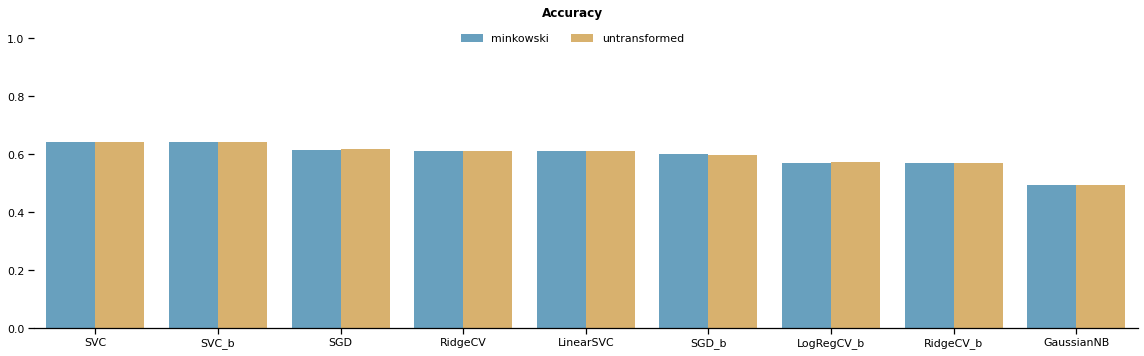

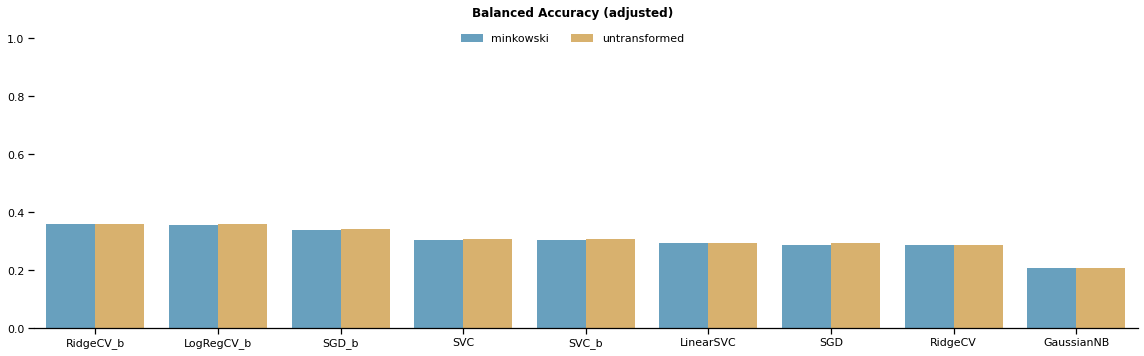

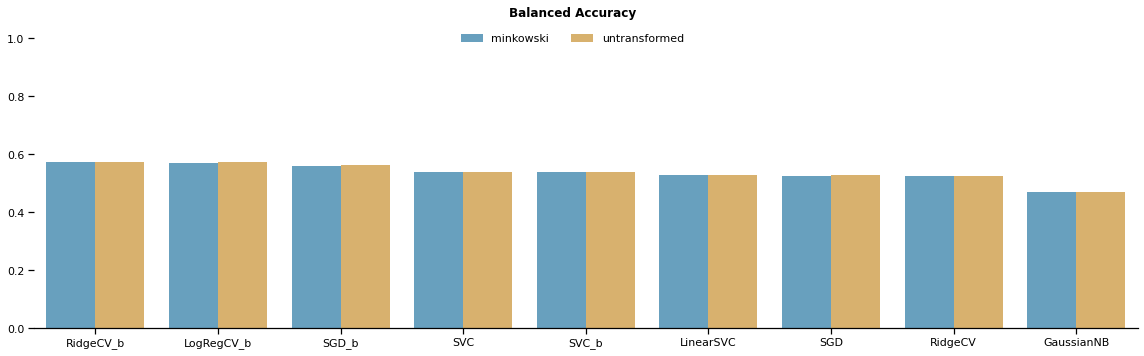

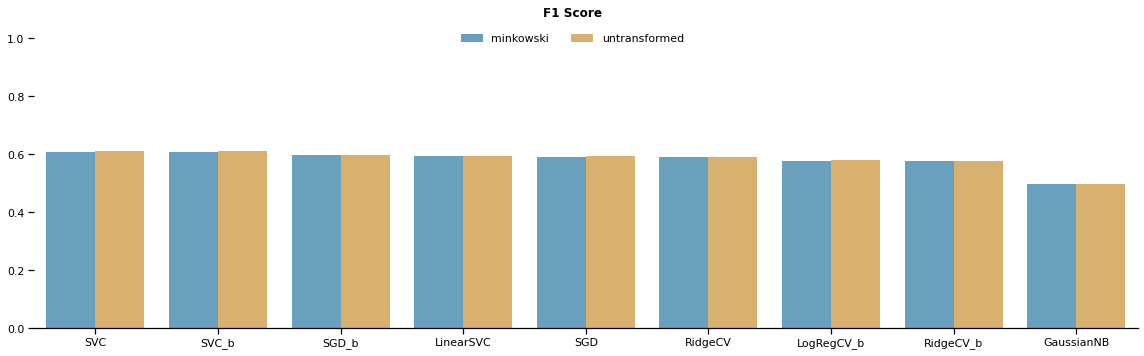

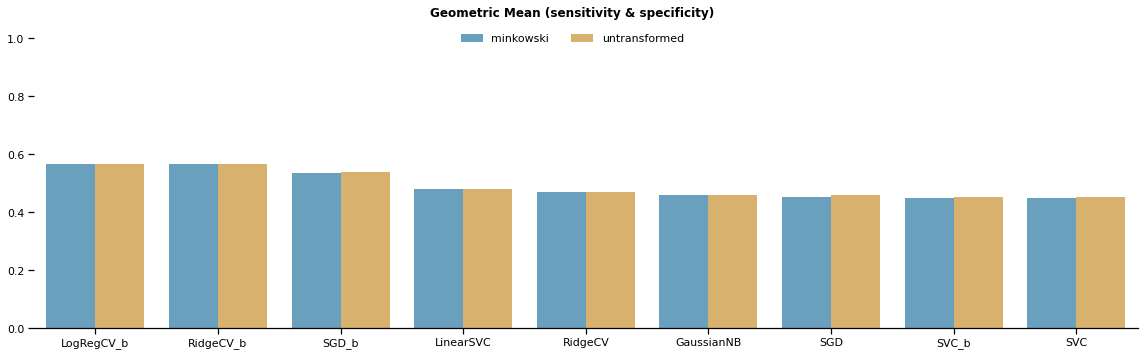

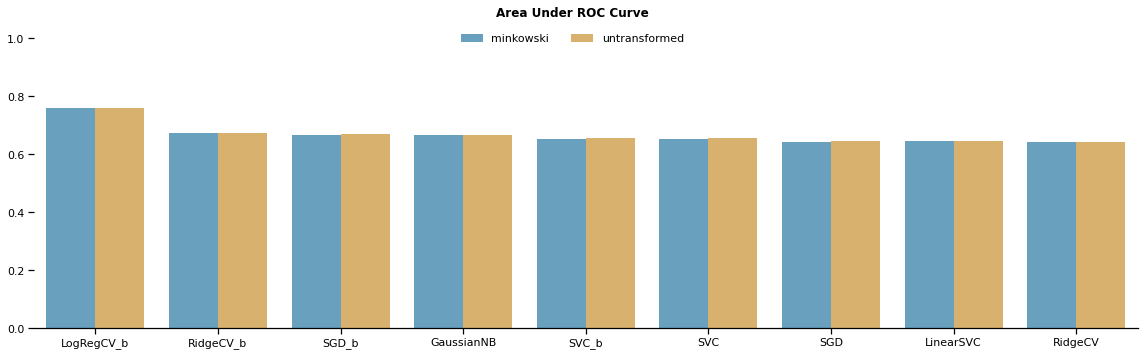

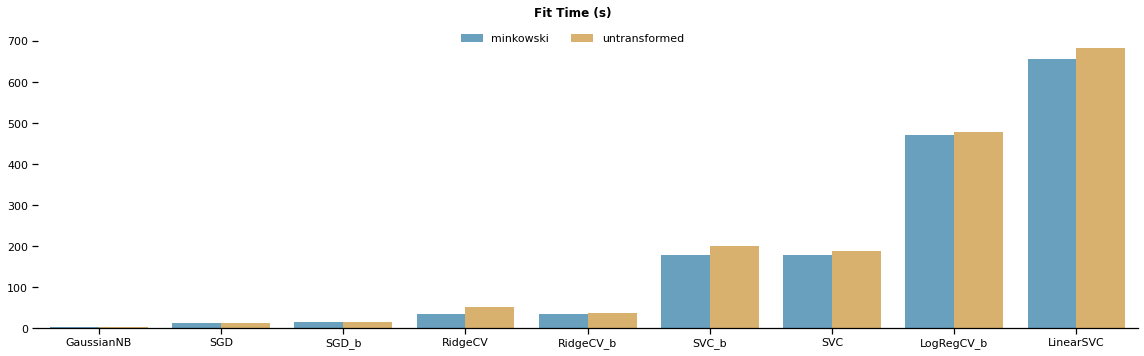

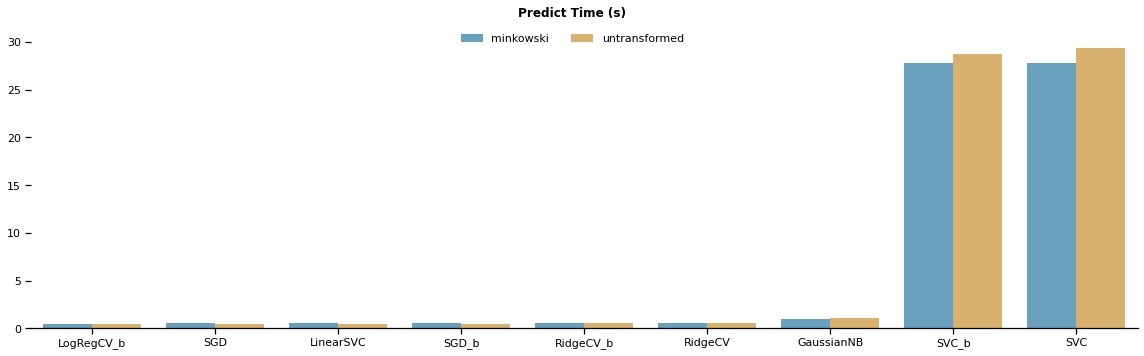

time: 3.12 s


In [14]:
for metric in tqdm(METRICS):
    plot_metric(metric, results_df)

# Prediction correlations

To estimate the degree of correlation between model predictions, we recorded an array of probability vector predictions per model per fold. The vectors are transformed to three columns that are reduced to one component with PCA. The absolute values of the correlation coefficients are calculated between these single components per model. These are averaged between folds for the final estimate.

<Figure size 864x864 with 0 Axes>

Pandas Apply: 100%|██████████| 1/1 [00:00<?, ?it/s]


{'GaussianNB': array([0.22187639, 0.22187639, 0.22187639, ..., 1.22187639, 1.22187639,
       1.22187639]), 'LinearSVC': array([-0.40788499, -0.40788499, -0.40788499, ...,  1.59211501,
        1.59211501,  1.59211501]), 'LogRegCV_b': array([-0.76767452, -0.76767452, -0.76767452, ...,  1.23232548,
        1.23232548,  1.23232548]), 'RidgeCV_b': array([-0.78390396, -0.78390396, -0.78390396, ...,  1.21609604,
        1.21609604,  1.21609604]), 'RidgeCV': array([-0.39276716, -0.39276716, -0.39276716, ...,  1.60723284,
        1.60723284,  1.60723284]), 'SGD': array([-0.33874315, -0.33874315, -0.33874315, ...,  1.66125685,
        1.66125685,  1.66125685]), 'SGD_b': array([-0.55513562, -0.55513562, -0.55513562, ...,  1.44486438,
        1.44486438,  1.44486438]), 'SVC': array([-0.25744775, -0.25744775, -0.25744775, ...,  1.74255225,
        1.74255225,  1.74255225]), 'SVC_b': array([-0.25744775, -0.25744775, -0.25744775, ...,  1.74255225,
        1.74255225,  1.74255225])}


Pandas Apply: 100%|██████████| 1/1 [00:00<?, ?it/s]


{'GaussianNB': array([-0.66608816, -0.66608816, -0.66608816, ...,  1.33391184,
        1.33391184,  1.33391184]), 'LinearSVC': array([-0.44481083, -0.44481083, -0.44481083, ..., -0.44481083,
        1.55518917,  1.55518917]), 'LogRegCV_b': array([-0.81542867,  1.18457133, -0.81542867, ...,  1.18457133,
        1.18457133,  1.18457133]), 'RidgeCV_b': array([-0.83781673,  1.16218327, -0.83781673, ...,  1.16218327,
        1.16218327,  1.16218327]), 'RidgeCV': array([-0.4127907, -0.4127907, -0.4127907, ..., -0.4127907,  1.5872093,
        1.5872093]), 'SGD': array([-0.40168344, -0.40168344, -0.40168344, ..., -0.40168344,
        1.59831656,  1.59831656]), 'SGD_b': array([-0.54382159, -0.54382159, -0.54382159, ...,  1.45617841,
        1.45617841,  1.45617841]), 'SVC': array([-0.37660535,  1.62339465, -0.37660535, ...,  1.62339465,
        1.62339465,  1.62339465]), 'SVC_b': array([-0.37660535,  1.62339465, -0.37660535, ...,  1.62339465,
        1.62339465,  1.62339465])}


Pandas Apply: 100%|██████████| 1/1 [00:00<?, ?it/s]


{'GaussianNB': array([-0.87701227, -0.87701227, -0.87701227, ...,  1.12298773,
        1.12298773,  1.12298773]), 'LinearSVC': array([-0.50468451, -0.50468451, -0.50468451, ..., -0.50468451,
        1.49531549,  1.49531549]), 'LogRegCV_b': array([ 1.07945546, -0.92054454, -0.92054454, ..., -0.92054454,
        1.07945546,  1.07945546]), 'RidgeCV_b': array([ 1.10637197, -0.89362803, -0.89362803, ...,  1.10637197,
        1.10637197,  1.10637197]), 'RidgeCV': array([-0.47921735, -0.47921735, -0.47921735, ..., -0.47921735,
        1.52078265,  1.52078265]), 'SGD': array([-0.47869973, -0.47869973, -0.47869973, ..., -0.47869973,
        1.52130027,  1.52130027]), 'SGD_b': array([-0.76748279, -0.76748279, -0.76748279, ..., -0.76748279,
        1.23251721,  1.23251721]), 'SVC': array([-0.42119157, -0.42119157, -0.42119157, ..., -0.42119157,
        1.57880843,  1.57880843]), 'SVC_b': array([-0.42119157, -0.42119157, -0.42119157, ..., -0.42119157,
        1.57880843,  1.57880843])}


Pandas Apply: 100%|██████████| 1/1 [00:00<?, ?it/s]


{'GaussianNB': array([-0.68771008, -0.68771008, -0.68771008, ...,  1.31228992,
        1.31228992,  1.31228992]), 'LinearSVC': array([-0.48665147, -0.48665147, -0.48665147, ...,  1.51334853,
        1.51334853,  1.51334853]), 'LogRegCV_b': array([-0.80709346, -0.80709346, -0.80709346, ...,  1.19290654,
        1.19290654,  1.19290654]), 'RidgeCV_b': array([-0.82768613, -0.82768613, -0.82768613, ...,  1.17231387,
        1.17231387,  1.17231387]), 'RidgeCV': array([-0.47502222, -0.47502222, -0.47502222, ...,  1.52497778,
        1.52497778,  1.52497778]), 'SGD': array([-0.42549164, -0.42549164, -0.42549164, ...,  1.57450836,
        1.57450836, -0.42549164]), 'SGD_b': array([-0.62855929, -0.62855929, -0.62855929, ...,  1.37144071,
        1.37144071,  1.37144071]), 'SVC': array([-0.34914809, -0.34914809, -0.34914809, ...,  1.65085191,
        1.65085191,  1.65085191]), 'SVC_b': array([-0.34914809, -0.34914809, -0.34914809, ...,  1.65085191,
        1.65085191,  1.65085191])}


Pandas Apply: 100%|██████████| 1/1 [00:00<?, ?it/s]


{'GaussianNB': array([-0.97090491,  1.02909509, -0.97090491, ...,  1.02909509,
        1.02909509,  1.02909509]), 'LinearSVC': array([ 1.43914832, -0.56085168, -0.56085168, ...,  1.43914832,
        1.43914832,  1.43914832]), 'LogRegCV_b': array([ 1.02836922, -0.97163078, -0.97163078, ...,  1.02836922,
        1.02836922,  1.02836922]), 'RidgeCV_b': array([ 1.05401645, -0.94598355, -0.94598355, ...,  1.05401645,
        1.05401645,  1.05401645]), 'RidgeCV': array([ 1.47017905, -0.52982095, -0.52982095, ...,  1.47017905,
        1.47017905,  1.47017905]), 'SGD': array([-0.51391241, -0.51391241, -0.51391241, ...,  1.48608759,
        1.48608759, -0.51391241]), 'SGD_b': array([-0.73542221, -0.73542221, -0.73542221, ...,  1.26457779,
        1.26457779,  1.26457779]), 'SVC': array([-0.46443262, -0.46443262, -0.46443262, ...,  1.53556738,
        1.53556738,  1.53556738]), 'SVC_b': array([-0.46443262, -0.46443262, -0.46443262, ...,  1.53556738,
        1.53556738,  1.53556738])}


Text(0.5, 0.98, 'prediction correlations: LOF minkowski')

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5]),
 [Text(0.5, 0, 'GaussianNB'),
  Text(1.5, 0, 'LinearSVC'),
  Text(2.5, 0, 'LogRegCV_b'),
  Text(3.5, 0, 'RidgeCV_b'),
  Text(4.5, 0, 'RidgeCV'),
  Text(5.5, 0, 'SGD'),
  Text(6.5, 0, 'SGD_b'),
  Text(7.5, 0, 'SVC'),
  Text(8.5, 0, 'SVC_b')])

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5]),
 [Text(0, 0.5, 'GaussianNB'),
  Text(0, 1.5, 'LinearSVC'),
  Text(0, 2.5, 'LogRegCV_b'),
  Text(0, 3.5, 'RidgeCV'),
  Text(0, 4.5, 'RidgeCV_b'),
  Text(0, 5.5, 'SGD'),
  Text(0, 6.5, 'SGD_b'),
  Text(0, 7.5, 'SVC'),
  Text(0, 8.5, 'SVC_b')])

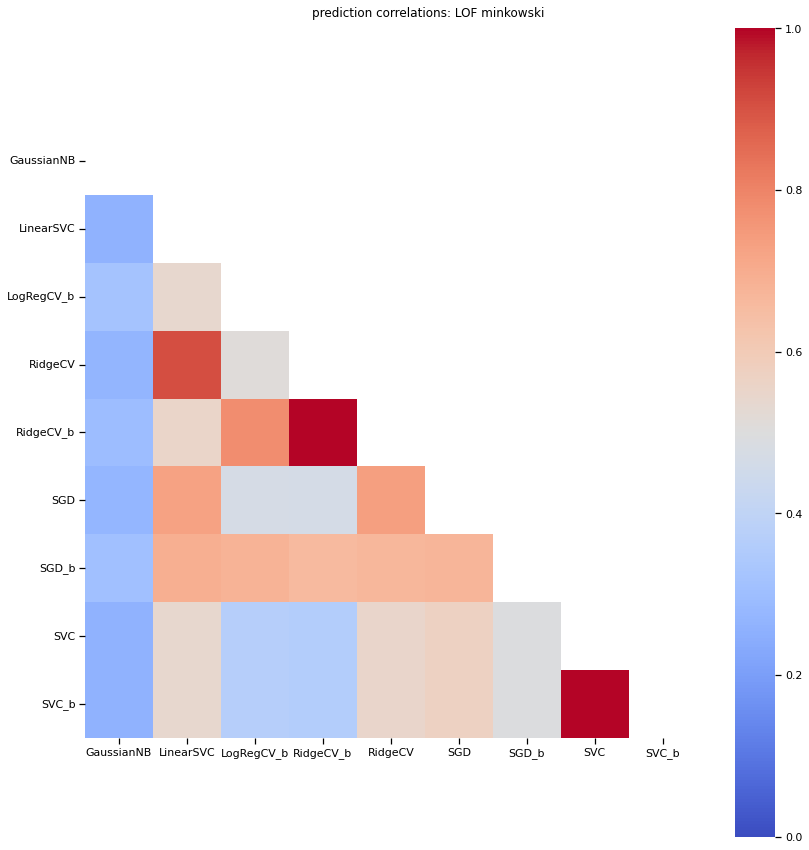

<Figure size 864x864 with 0 Axes>

Pandas Apply: 100%|██████████| 1/1 [00:00<?, ?it/s]


{'GaussianNB': array([0.22469246, 0.22469246, 0.22469246, ..., 1.22469246, 1.22469246,
       1.22469246]), 'LinearSVC': array([-0.40877427, -0.40877427, -0.40877427, ...,  1.59122573,
        1.59122573,  1.59122573]), 'LogRegCV_b': array([-0.77560397, -0.77560397, -0.77560397, ...,  1.22439603,
        1.22439603,  1.22439603]), 'RidgeCV_b': array([-0.79242626, -0.79242626, -0.79242626, ...,  1.20757374,
        1.20757374,  1.20757374]), 'RidgeCV': array([-0.39261894, -0.39261894, -0.39261894, ...,  1.60738106,
        1.60738106,  1.60738106]), 'SGD': array([-0.35534312, -0.35534312, -0.35534312, ...,  1.64465688,
        1.64465688,  1.64465688]), 'SGD_b': array([-0.51726693, -0.51726693, -0.51726693, ...,  1.48273307,
        1.48273307,  1.48273307]), 'SVC': array([-0.25848525, -0.25848525, -0.25848525, ...,  1.74151475,
        1.74151475,  1.74151475]), 'SVC_b': array([-0.25848525, -0.25848525, -0.25848525, ...,  1.74151475,
        1.74151475,  1.74151475])}


Pandas Apply: 100%|██████████| 1/1 [00:00<?, ?it/s]


{'GaussianNB': array([-0.6578445, -0.6578445, -0.6578445, ...,  1.3421555,  1.3421555,
        1.3421555]), 'LinearSVC': array([-0.44342242, -0.44342242, -0.44342242, ..., -0.44342242,
        1.55657758,  1.55657758]), 'LogRegCV_b': array([-0.8107428,  1.1892572, -0.8107428, ...,  1.1892572,  1.1892572,
        1.1892572]), 'RidgeCV_b': array([-0.83703575,  1.16296425, -0.83703575, ...,  1.16296425,
        1.16296425,  1.16296425]), 'RidgeCV': array([-0.41218327, -0.41218327, -0.41218327, ..., -0.41218327,
        1.58781673,  1.58781673]), 'SGD': array([-0.39361333, -0.39361333, -0.39361333, ..., -0.39361333,
        1.60638667,  1.60638667]), 'SGD_b': array([-0.62929538, -0.62929538, -0.62929538, ...,  1.37070462,
        1.37070462,  1.37070462]), 'SVC': array([-0.37695245,  1.62304755, -0.37695245, ...,  1.62304755,
        1.62304755,  1.62304755]), 'SVC_b': array([-0.37695245,  1.62304755, -0.37695245, ...,  1.62304755,
        1.62304755,  1.62304755])}


Pandas Apply: 100%|██████████| 1/1 [00:00<?, ?it/s]


{'GaussianNB': array([-0.88001449, -0.88001449, -0.88001449, ...,  1.11998551,
        1.11998551,  1.11998551]), 'LinearSVC': array([-0.50370102, -0.50370102, -0.50370102, ..., -0.50370102,
        1.49629898,  1.49629898]), 'LogRegCV_b': array([ 1.08411408, -0.91588592, -0.91588592, ..., -0.91588592,
        1.08411408,  1.08411408]), 'RidgeCV_b': array([ 1.10725193, -0.89274807, -0.89274807, ...,  1.10725193,
        1.10725193,  1.10725193]), 'RidgeCV': array([-0.47699156, -0.47699156, -0.47699156, ..., -0.47699156,
        1.52300844,  1.52300844]), 'SGD': array([-0.47409286, -0.47409286, -0.47409286, ..., -0.47409286,
        1.52590714,  1.52590714]), 'SGD_b': array([-0.77017444, -0.77017444, -0.77017444, ..., -0.77017444,
        1.22982556,  1.22982556]), 'SVC': array([-0.42569491, -0.42569491, -0.42569491, ..., -0.42569491,
        1.57430509,  1.57430509]), 'SVC_b': array([-0.42569491, -0.42569491, -0.42569491, ..., -0.42569491,
        1.57430509,  1.57430509])}


Pandas Apply: 100%|██████████| 1/1 [00:00<?, ?it/s]


{'GaussianNB': array([-0.69292586, -0.69292586, -0.69292586, ...,  1.30707414,
        1.30707414,  1.30707414]), 'LinearSVC': array([-0.48259475, -0.48259475, -0.48259475, ...,  1.51740525,
        1.51740525,  1.51740525]), 'LogRegCV_b': array([-0.80334583, -0.80334583, -0.80334583, ...,  1.19665417,
        1.19665417,  1.19665417]), 'RidgeCV_b': array([-0.8247112, -0.8247112, -0.8247112, ...,  1.1752888,  1.1752888,
        1.1752888]), 'RidgeCV': array([-0.47142912, -0.47142912, -0.47142912, ...,  1.52857088,
        1.52857088,  1.52857088]), 'SGD': array([-0.44724336, -0.44724336, -0.44724336, ...,  1.55275664,
        1.55275664, -0.44724336]), 'SGD_b': array([-0.6413476, -0.6413476, -0.6413476, ...,  1.3586524,  1.3586524,
        1.3586524]), 'SVC': array([-0.35231619, -0.35231619, -0.35231619, ...,  1.64768381,
        1.64768381,  1.64768381]), 'SVC_b': array([-0.35231619, -0.35231619, -0.35231619, ...,  1.64768381,
        1.64768381,  1.64768381])}


Pandas Apply: 100%|██████████| 1/1 [00:00<?, ?it/s]


{'GaussianNB': array([-0.98136947,  1.01863053, -0.98136947, ...,  1.01863053,
        1.01863053,  1.01863053]), 'LinearSVC': array([ 1.43745463, -0.56254537, -0.56254537, ...,  1.43745463,
        1.43745463,  1.43745463]), 'LogRegCV_b': array([ 1.02625212, -0.97374788, -0.97374788, ...,  1.02625212,
        1.02625212,  1.02625212]), 'RidgeCV_b': array([ 1.05038713, -0.94961287, -0.94961287, ...,  1.05038713,
        1.05038713,  1.05038713]), 'RidgeCV': array([ 1.46788047, -0.53211953, -0.53211953, ...,  1.46788047,
        1.46788047,  1.46788047]), 'SGD': array([-0.52776434, -0.52776434, -0.52776434, ...,  1.47223566,
        1.47223566, -0.52776434]), 'SGD_b': array([-0.81986451, -0.81986451, -0.81986451, ...,  1.18013549,
        1.18013549,  1.18013549]), 'SVC': array([-0.47271957, -0.47271957, -0.47271957, ...,  1.52728043,
        1.52728043,  1.52728043]), 'SVC_b': array([-0.47271957, -0.47271957, -0.47271957, ...,  1.52728043,
        1.52728043,  1.52728043])}


Text(0.5, 0.98, 'prediction correlations: LOF untransformed')

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5]),
 [Text(0.5, 0, 'GaussianNB'),
  Text(1.5, 0, 'LinearSVC'),
  Text(2.5, 0, 'LogRegCV_b'),
  Text(3.5, 0, 'RidgeCV_b'),
  Text(4.5, 0, 'RidgeCV'),
  Text(5.5, 0, 'SGD'),
  Text(6.5, 0, 'SGD_b'),
  Text(7.5, 0, 'SVC'),
  Text(8.5, 0, 'SVC_b')])

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5]),
 [Text(0, 0.5, 'GaussianNB'),
  Text(0, 1.5, 'LinearSVC'),
  Text(0, 2.5, 'LogRegCV_b'),
  Text(0, 3.5, 'RidgeCV'),
  Text(0, 4.5, 'RidgeCV_b'),
  Text(0, 5.5, 'SGD'),
  Text(0, 6.5, 'SGD_b'),
  Text(0, 7.5, 'SVC'),
  Text(0, 8.5, 'SVC_b')])

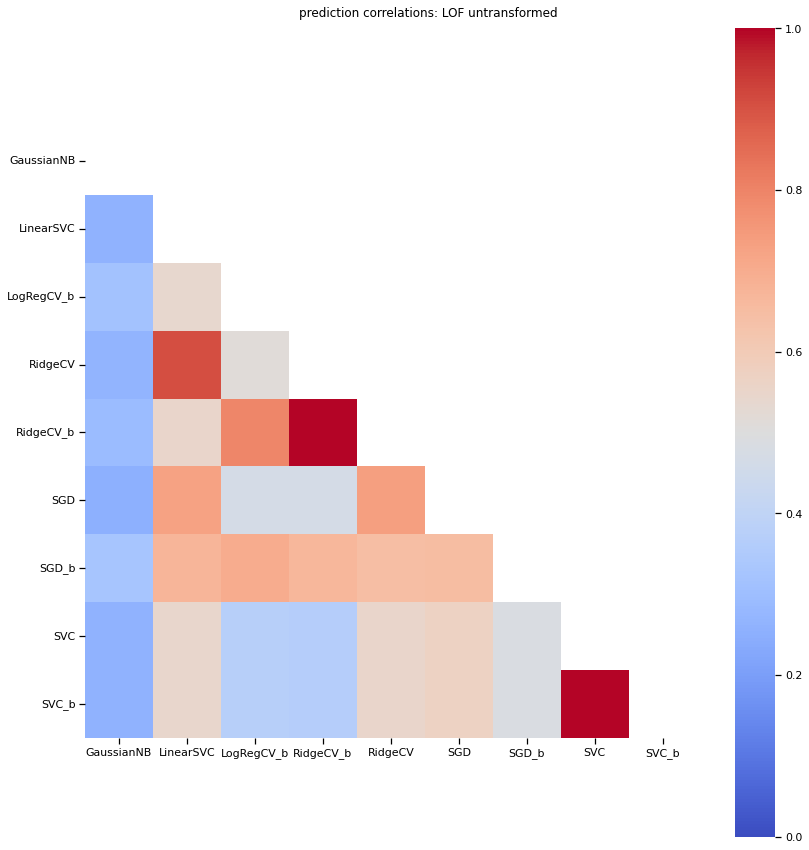

time: 2.22 s


In [15]:
def average_prediction_correlations(distance: str) -> pd.DataFrame:
    """Estimates the correlations of model predictions and returns a DataFrame"""
    distance_df = pd.DataFrame(predictions_).query(f"LOF == '{distance}'")
    fold_correlation_dfs = []
    for fold in sorted(np.unique(distance_df.fold)):
        fold_df = distance_df.query(f"fold == {fold}")
        model_predictions = {
            model: np.squeeze(
                PCA(n_components=1, random_state=SEED).fit_transform(
                    pd.DataFrame(
                        np.hstack(
                            fold_df.query(f"model == '{model}'")
                            .y_pred.swifter.apply(np.asarray)
                            .values
                        )
                    )
                )
            )
            for model in MODELS
        }
        print(model_predictions)
        fold_correlation_dfs.append(
            pd.DataFrame(model_predictions).corr().swifter.apply(abs)
        )
    return (_ := pd.concat(fold_correlation_dfs)).groupby(_.index).mean()


for distance in {"minkowski", "untransformed"}:
    plt.figure(figsize=(12, 12))
    # classifiers whose predictions do not vary (e.g., dummy) produce NaN correlations and are dropped from visualization
    g = sns.heatmap(
        data=(
            df := average_prediction_correlations(distance)
            .dropna(axis="columns", how="all")
            .dropna(axis="index", how="all")
        ),
        vmin=0,
        vmax=1,
        cmap="coolwarm",
        square=True,
        mask=np.triu(np.ones_like(df, dtype=bool)),
    )
    plt.suptitle(f"prediction correlations: LOF {distance}")
    plt.xticks(rotation=0)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    del df
    del g
    _ = gc_collect()

# Discussion

RidgeClassifierCV (balanced), SVC, and LogisticRegressionCV (balanced) are the top contenders from this notebook. Ridge and LogReg predictions appear somewhat correlated as do those of SVC and Ridge. However, the predictions of SVC and LogReg are less correlated and therefore may be good candidates for ensembling. SGD as a consistent runner up and may be worthy of consideration as well.

Outlier removal didn't seem to make much of a difference. The most performant models by each metric were trained on the untransformed data.

In [16]:
print(f"Time elapsed since notebook_begin_time: {time() - notebook_begin_time} s")
_ = gc_collect()

Time elapsed since notebook_begin_time: 17108.18603157997 s
time: 105 ms


[^top](#Contents)